# denoising_wSURE.py In iPython Notebook Form


# SetUp

In [1]:
# Based on denoising.ipynb from https://github.com/DmitryUlyanov/deep-image-prior
# Clone deep image prior https://github.com/DmitryUlyanov/deep-image-prior within this directory to download dependencies

# # Import libs
from __future__ import print_function

from models import skip

import time

import torch.optim

from utils.denoising_utils import *

import copy

from matplotlib import pyplot as plt

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
dtype = torch.cuda.FloatTensor

# torch.backends.cudnn.enabled = False
# torch.backends.cudnn.benchmark = False
# dtype = torch.float32

imsize=512
PLOT =  True
sigma = 25
sigma_ = sigma / 255.

In [2]:
# torch.cuda.device(3) # this is gpu 2
# torch.cuda.device(1) # this is gpu 2
# torch.cuda.device(2) # this is gpu 2

for i in range(torch.cuda.device_count()): 
    print(torch.cuda.get_device_name(i))
    print(i)
# torch.cuda.device(0) GPU process 2 


TITAN Xp
0
TITAN Xp
1
TITAN X (Pascal)
2
TITAN X (Pascal)
3


In [3]:
print(torch.cuda.get_device_name(torch.cuda.current_device()))

TITAN Xp


In [4]:
torch.cuda.device_count()

4

In [5]:
help(torch.cuda.device)


Help on class device in module torch.cuda:

class device(builtins.object)
 |  Context-manager that changes the selected device.
 |  
 |  Arguments:
 |      idx (int): device index to select. It's a no-op if this argument
 |          is negative.
 |  
 |  Methods defined here:
 |  
 |  __enter__(self)
 |  
 |  __exit__(self, *args)
 |  
 |  __init__(self, idx)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



## Getting Image

Please input the path to your image. 

In [6]:
## denoising
fname = 'F16_GT.png'
fname = 'data/denoising/'+fname

## making sure its noise and testing with SURE

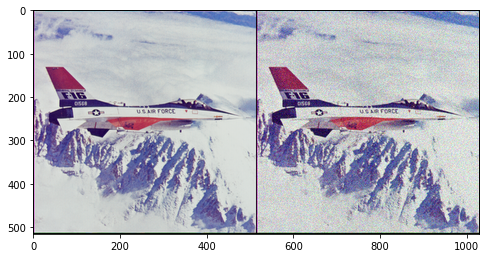

Number of params: 3621104


In [7]:

img_pil = crop_image(get_image(fname, imsize)[0], d=32)
img_np = pil_to_np(img_pil)

img_noisy_pil, img_noisy_np = get_noisy_image(img_np, sigma_)

if PLOT:
    plot_image_grid([img_np, img_noisy_np], 4, 6);


INPUT = 'noise'  # 'meshgrid'
pad = 'reflection'
OPT_OVER = 'net'  # 'net,input'

TrainwSURE=True
if TrainwSURE:
    reg_noise_std = 0
else:
    reg_noise_std =  1. / 30. #Need to jitter input when training only wrt data fidelity term
LR = .001

OPTIMIZER = 'adam'  # 'LBFGS'
show_every = 100


num_iter = 500 ### CHANGE IF YOU WANT. 

input_depth = img_np.shape[0]
output_depth = img_np.shape[0]
figsize = 5

net = skip(input_depth, output_depth, num_channels_down=[128, 128, 128, 128, 128, 128, 128, 128],
           num_channels_up=[128, 128, 128, 128, 128, 128, 128, 128],
           num_channels_skip=[15, 13, 11, 9, 7, 5, 3, 1],
           upsample_mode=['nearest', 'nearest', 'nearest', 'nearest', 'bilinear', 'bilinear', 'bilinear', 'bilinear'],
           need_sigmoid=True, need_bias=True, pad=pad).type(dtype)

net = net.type(dtype)


net_input = torch.reshape(torch.from_numpy(img_noisy_np).type(dtype).detach(),
                          (1, input_depth, img_pil.size[1], img_pil.size[0]))

# Compute number of parameters
s = sum([np.prod(list(p.size())) for p in net.parameters()]);
print('Number of params: %d' % s)


## True optimization Setup

In [8]:
# Loss
mse_el = torch.nn.MSELoss(reduction="elementwise_mean").type(dtype)
mse_norm = torch.nn.MSELoss().type(dtype)

img_noisy_var = np_to_torch(img_noisy_np).type(dtype)
img_clean_var = np_to_torch(img_np).type(dtype)

net_input_saved = net_input.data.clone()
input_noise_vec = net_input.data.clone()

# SURE

In [9]:
help(mse_el)

Help on MSELoss in module torch.nn.modules.loss object:

class MSELoss(_Loss)
 |  Creates a criterion that measures the mean squared error between
 |  `n` elements in the input `x` and target `y`.
 |  
 |  The loss can be described as:
 |  
 |  .. math::
 |      \ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad
 |      l_n = \left( x_n - y_n \right)^2,
 |  
 |  where :math:`N` is the batch size. If reduce is ``True``, then:
 |  
 |  .. math::
 |      \ell(x, y) = \begin{cases}
 |          \operatorname{mean}(L), & \text{if}\; \text{size_average} = \text{True},\\
 |          \operatorname{sum}(L),  & \text{if}\; \text{size_average} = \text{False}.
 |      \end{cases}
 |  
 |  The sum operation still operates over all the elements, and divides by `n`.
 |  
 |  The division by `n` can be avoided if one sets :attr:`size_average` to ``False``.
 |  
 |  To get a batch of losses, a loss per batch element, set `reduce` to
 |  ``False``. These losses are not averaged and are not affected by
 |  `s

In [15]:
def sure(out, mcdiv=1, og=False):

    epsilon = 1e-3  # * torch.max(net_input)
    eta = input_noise_vec.normal_()
    net_input_perturbed = net_input.data.clone() + (eta * epsilon)
    out_perturbed = net(net_input_perturbed)
    dx=out_perturbed - out

    if not og: 
        fidelity_loss = mse_norm(out, img_noisy_var)
        # Calculate the MC divergence and SURE loss before network changes (loss.backward())
        eta_dx = torch.sum(eta * dx)  # Inner product between eta and (x_perturbed-x). They must have the same dimensions
        MCdiv = eta_dx / epsilon
        div_term = 2. * sigma_ ** 2 * MCdiv / n
        return (fidelity_loss - sigma_ ** 2 + div_term, div_term)
    
    #compute SURE via pixels. 
    #TODO: fix this so it goes by pixels rather than the image. 
    error_map_loss = mse_el(out, img_noisy_var)
    div_term = 2. * sigma_ **2 * (eta/ epsilon) 
    return (error_map_loss - sigma_**2 + div_term)*100, div_term
    

### Variables used to calculate the SURE loss


In [16]:
testing = True  

In [23]:
n = img_np.size

global MSE_losses_wrtinput
global MSE_losses_wrttruth
global SURE_losses
global Divergences_terms
MSE_losses_wrtnoisy = np.zeros(num_iter)
MSE_losses_wrttruth = np.zeros(num_iter)
SURE_losses = np.zeros(num_iter)
Divergences_terms = np.zeros(num_iter)

i = 0

global min_loss
min_loss=np.inf

def closure():
    global i

    if reg_noise_std > 0:
        net_input.data = net_input_saved + (input_noise_vec.normal_() * reg_noise_std)

    out_0 = net(net_input_saved)
    out = net(net_input)
    out_2 = net(net_input)
    
    global MSE_losses_wrtnoisy
    global MSE_losses_wrttruth

    global SURE_losses
    global Divergences_terms

#     if not testing: 
    fidelity_loss = mse_norm(out, img_noisy_var)
    true_loss = mse_norm(out, img_clean_var)
    MSE_losses_wrtnoisy[i] = fidelity_loss
    MSE_losses_wrttruth[i] = true_loss

    # Sanity check.
    SURE_loss, div_term = sure(out, og=testing)
    if not testing: 
        SURE_losses[i] = SURE_loss
        Divergences_terms[i] = div_term
        global min_loss
        global best_net
        if SURE_loss<min_loss:
            min_loss=SURE_loss
            best_net=copy.deepcopy(net)
            
    print('Iteration %05d' % i)
#     print('Iteration %05d    Loss %f' % (i, fidelity_loss.data[0]), '\r', end='')
    if PLOT and i % show_every == 0:
        out_0_np = torch_to_np(out_0)
        plot_image_grid([np.clip(out_0_np, 0, 1)], factor=figsize, nrow=1)
        out_np = torch_to_np(out)
        plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)
        out_2_np = torch_to_np(out_2)
        plot_image_grid([np.clip(out_2_np, 0, 1)], factor=figsize, nrow=1)

    i += 1
    if not testing: 
        if TrainwSURE:
            SURE_loss.backward()
            return SURE_loss
        else:
            fidelity_loss.backward()
            return fidelity_loss
    else: 
#         SURE_loss.backward() # causes error. But how do I go backwards in SURE for matrix. 
        return SURE_loss
    # true_loss.backward()
    # return true_loss


# Optimize!

In [24]:
torch.cuda.memory_allocated()

31180288

Starting optimization with ADAM
Iteration 00000


/home/gnahum/anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/home/gnahum/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


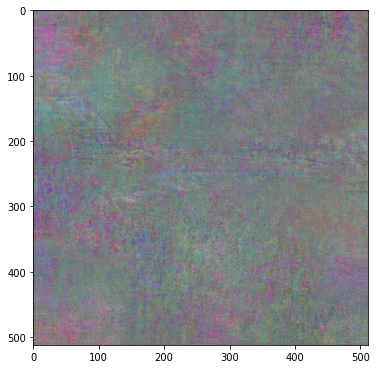

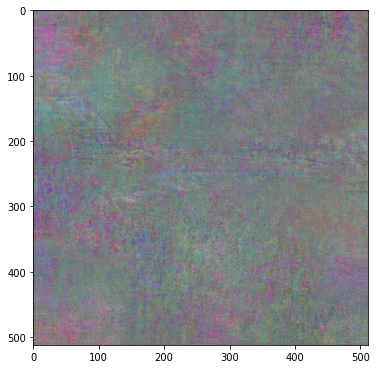

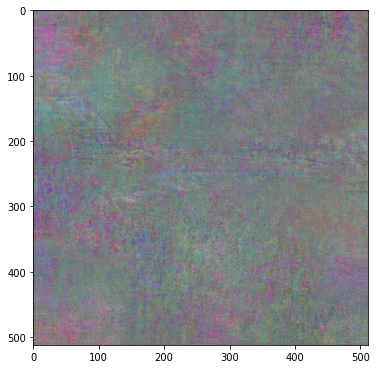

RuntimeError: grad can be implicitly created only for scalar outputs

In [25]:
start_time = time.time()
p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)
end_time=time.time() - start_time

out_np = torch_to_np(net(net_input))
q = plot_image_grid([np.clip(out_np, 0, 1), img_np], factor=13);


In [39]:
# ONLY RUN THIS CELL IF YOU WANT TO CLEAR CACHE
if input() != "": 
    torch.cuda.empty_cache()
    torch.cuda.empty()
    print("cleared")
else: 
    print("no worries")



no worries


# Evaluating Error

In [23]:
def EvalError_np(x_hat,x_true):
    x_hat=np.reshape(x_hat,(n,))
    x_true=np.reshape(x_true,(n,))
    mse=np.mean(np.square(x_hat-x_true),axis=0)
    xnorm2=np.mean(np.square( x_true),axis=0)
    mse_thisiter=mse
    nmse_thisiter=mse/xnorm2
    psnr_thisiter=10.*np.log(1./mse)/np.log(10.)
    return mse_thisiter, nmse_thisiter, psnr_thisiter
in_np=torch_to_np(net_input_saved)
out_np = torch_to_np(net(net_input_saved))
[_,_,PSNR_orig]=EvalError_np(in_np,img_np)
[_,_,PSNR_final]=EvalError_np(out_np,img_np)

out_np = torch_to_np(best_net(net_input_saved))
[_,_,PSNR_final_best]=EvalError_np(out_np,img_np)
print(PSNR_final)
print(PSNR_final_best)



29.569481718955362
22.188166415660582


/home/gnahum/anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/home/gnahum/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


# Plotting

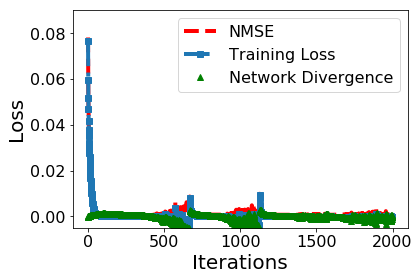

In [24]:
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
if TrainwSURE:
    fig4 = plt.figure()
    l1,=plt.plot(range(num_iter), MSE_losses_wrttruth,'--r',label='NMSE',linewidth=4.0)
    l2,=plt.plot(range(num_iter), SURE_losses, 's-.',label='Training Loss',linewidth=4.0)
    l3, = plt.plot(range(num_iter), Divergences_terms, 'g^', label='Network Divergence', linewidth=4.0)
    plt.legend((l1,l2,l3),('NMSE','Training Loss','Network Divergence'))
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.ylim(ymin=-0.005,ymax=0.09)
    plt.show()
#     fig4.savefig('./DeepPrior_TrainedwrtSURE.png')
else:
    fig4 = plt.figure()
    l1,=plt.plot(range(num_iter), MSE_losses_wrttruth,'--r',label='NMSE',linewidth=4.0)
    l2,=plt.plot(range(num_iter), MSE_losses_wrtnoisy, 's-.',label='Training Loss',linewidth=4.0)
    l3, = plt.plot(range(num_iter), Divergences_terms, 'g^', label='Network Divergence', linewidth=4.0)
    plt.legend((l1,l2,l3),('NMSE','Training Loss','Network Divergence'))
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.ylim(ymin=-0.005,ymax=0.09)
    plt.show()

In [ ]:
# Based on denoising.ipynb from https://github.com/DmitryUlyanov/deep-image-prior
# Clone deep image prior https://github.com/DmitryUlyanov/deep-image-prior within this directory to download dependencies

# # Import libs
from __future__ import print_function

from models import skip

import time

import torch.optim

from utils.denoising_utils import *

import copy

from matplotlib import pyplot as plt

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
dtype = torch.cuda.FloatTensor
# torch.backends.cudnn.enabled = False
# torch.backends.cudnn.benchmark = False
# dtype = torch.float32

imsize=512
PLOT =  True
sigma = 25
sigma_ = sigma / 255.

## denoising
fname = 'F16_GT.png'
fname = 'data/denoising/'+fname

img_pil = crop_image(get_image(fname, imsize)[0], d=32)
img_np = pil_to_np(img_pil)

img_noisy_pil, img_noisy_np = get_noisy_image(img_np, sigma_)

if PLOT:
    plot_image_grid([img_np, img_noisy_np], 4, 6);


INPUT = 'noise'  # 'meshgrid'
pad = 'reflection'
OPT_OVER = 'net'  # 'net,input'

TrainwSURE=True
if TrainwSURE:
    reg_noise_std = 0
else:
    reg_noise_std =  1. / 30. #Need to jitter input when training only wrt data fidelity term
LR = .001

OPTIMIZER = 'adam'  # 'LBFGS'
show_every = 100


num_iter = 2000

input_depth = img_np.shape[0]
output_depth = img_np.shape[0]
figsize = 5

net = skip(input_depth, output_depth, num_channels_down=[128, 128, 128, 128, 128, 128, 128, 128],
           num_channels_up=[128, 128, 128, 128, 128, 128, 128, 128],
           num_channels_skip=[15, 13, 11, 9, 7, 5, 3, 1],
           upsample_mode=['nearest', 'nearest', 'nearest', 'nearest', 'bilinear', 'bilinear', 'bilinear', 'bilinear'],
           need_sigmoid=True, need_bias=True, pad=pad).type(dtype)

net = net.type(dtype)


net_input = torch.reshape(torch.from_numpy(img_noisy_np).type(dtype).detach(),
                          (1, input_depth, img_pil.size[1], img_pil.size[0]))

# Compute number of parameters
s = sum([np.prod(list(p.size())) for p in net.parameters()]);
print('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_noisy_var = np_to_torch(img_noisy_np).type(dtype)
img_clean_var = np_to_torch(img_np).type(dtype)

# # Optimize
net_input_saved = net_input.data.clone()
input_noise_vec = net_input.data.clone()

# Variables used to calculate the SURE loss
n = img_np.size

global MSE_losses_wrtinput
global MSE_losses_wrttruth
global SURE_losses
global Divergences_terms
MSE_losses_wrtnoisy = np.zeros(num_iter)
MSE_losses_wrttruth = np.zeros(num_iter)
SURE_losses = np.zeros(num_iter)
Divergences_terms = np.zeros(num_iter)

i = 0

global min_loss
min_loss=np.inf

def closure():
    global i

    if reg_noise_std > 0:
        net_input.data = net_input_saved + (input_noise_vec.normal_() * reg_noise_std)

    out_0 = net(net_input_saved)
    out = net(net_input)
    out_2 = net(net_input)

    fidelity_loss = mse(out, img_noisy_var)
    true_loss = mse(out, img_clean_var)

    global MSE_losses_wrtnoisy
    global MSE_losses_wrttruth
    MSE_losses_wrtnoisy[i] = fidelity_loss
    MSE_losses_wrttruth[i] = true_loss

    # Calculate the MC divergence and SURE loss before network changes (loss.backward())
    epsilon = 1e-3  # * torch.max(net_input)
    eta = input_noise_vec.normal_()
    net_input_perturbed = net_input.data.clone() + (eta * epsilon)
    out_perturbed = net(net_input_perturbed)
    dx=out_perturbed - out
    eta_dx = torch.sum(eta * dx)  # Inner product between eta and (x_perturbed-x). They must have the same dimensions
    MCdiv = eta_dx / epsilon
    div_term = 2. * sigma_ ** 2 * MCdiv / n


    global SURE_losses
    global Divergences_terms

    SURE_loss = fidelity_loss - sigma_ ** 2 + div_term

    SURE_losses[i] = SURE_loss
    Divergences_terms[i] = div_term

    global min_loss
    global best_net
    if SURE_loss<min_loss:
        min_loss=SURE_loss
        best_net=copy.deepcopy(net)

    print('Iteration %05d    Loss %f' % (i, fidelity_loss.data[0]), '\r', end='')
    if PLOT and i % show_every == 0:
        out_0_np = torch_to_np(out_0)
        plot_image_grid([np.clip(out_0_np, 0, 1)], factor=figsize, nrow=1)
        out_np = torch_to_np(out)
        plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)
        out_2_np = torch_to_np(out_2)
        plot_image_grid([np.clip(out_2_np, 0, 1)], factor=figsize, nrow=1)

    i += 1
    if TrainwSURE:
        SURE_loss.backward()
        return SURE_loss
    else:
        fidelity_loss.backward()
        return fidelity_loss
    # true_loss.backward()
    # return true_loss

start_time = time.time()
p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)
end_time=time.time() - start_time


out_np = torch_to_np(net(net_input))
q = plot_image_grid([np.clip(out_np, 0, 1), img_np], factor=13);

def EvalError_np(x_hat,x_true):
    x_hat=np.reshape(x_hat,(n,))
    x_true=np.reshape(x_true,(n,))
    mse=np.mean(np.square(x_hat-x_true),axis=0)
    xnorm2=np.mean(np.square( x_true),axis=0)
    mse_thisiter=mse
    nmse_thisiter=mse/xnorm2
    psnr_thisiter=10.*np.log(1./mse)/np.log(10.)
    return mse_thisiter, nmse_thisiter, psnr_thisiter
in_np=torch_to_np(net_input_saved)
out_np = torch_to_np(net(net_input_saved))
[_,_,PSNR_orig]=EvalError_np(in_np,img_np)
[_,_,PSNR_final]=EvalError_np(out_np,img_np)

out_np = torch_to_np(best_net(net_input_saved))
[_,_,PSNR_final_best]=EvalError_np(out_np,img_np)

print(PSNR_final)
print(PSNR_final_best)

SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
if TrainwSURE:
    fig4 = plt.figure()
    l1,=plt.plot(range(num_iter), MSE_losses_wrttruth,'--r',label='NMSE',linewidth=4.0)
    l2,=plt.plot(range(num_iter), SURE_losses, 's-.',label='Training Loss',linewidth=4.0)
    l3, = plt.plot(range(num_iter), Divergences_terms, 'g^', label='Network Divergence', linewidth=4.0)
    plt.legend((l1,l2,l3),('NMSE','Training Loss','Network Divergence'))
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.ylim(ymin=-0.005,ymax=0.09)
    # plt.show()
    fig4.savefig('./DeepPrior_TrainedwrtSURE.png')
else:
    fig4 = plt.figure()
    l1,=plt.plot(range(num_iter), MSE_losses_wrttruth,'--r',label='NMSE',linewidth=4.0)
    l2,=plt.plot(range(num_iter), MSE_losses_wrtnoisy, 's-.',label='Training Loss',linewidth=4.0)
    l3, = plt.plot(range(num_iter), Divergences_terms, 'g^', label='Network Divergence', linewidth=4.0)
    plt.legend((l1,l2,l3),('NMSE','Training Loss','Network Divergence'))
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.ylim(ymin=-0.005,ymax=0.09)
    # plt.show()
